<a href="https://colab.research.google.com/github/lollomante/ML_Cats/blob/main/Gina_vs_Shiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gina vs Shiro

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers
from google.colab import drive

## Constants

In [2]:
Path_to_dataset = '/content/drive/MyDrive/ML - Cats/Gina vs Shiro'
validation_split_ratio = 0.2
seed = 123
import_batch_size = None

image_sizes = (150,150,3) # size to crop images
batch_size = 32

## Load dataset and split

In [4]:
drive.mount('/content/drive')
# Load the training dataset
learning_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_dataset,
                  validation_split=validation_split_ratio,
                  subset="training",
                  seed=seed,
                  batch_size=import_batch_size
                )

# Load the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  Path_to_dataset,
                  validation_split=validation_split_ratio,
                  subset="validation",
                  seed=seed,
                  batch_size=import_batch_size
                )

Mounted at /content/drive
Found 255 files belonging to 3 classes.
Using 204 files for training.
Found 255 files belonging to 3 classes.
Using 51 files for validation.


## Explore dataset

### Number of samples

In [5]:
# TODO: deal with non full batches
batch_size = import_batch_size
if (batch_size == None):
    batch_size = 1
print('Number of training samples: %d' %(int(tf.data.experimental.cardinality(learning_dataset))*batch_size))
print('Number of validation samples: %d' %(int(tf.data.experimental.cardinality(validation_dataset))*batch_size))

Number of training samples: 204
Number of validation samples: 51


### Show some samples of the dataset

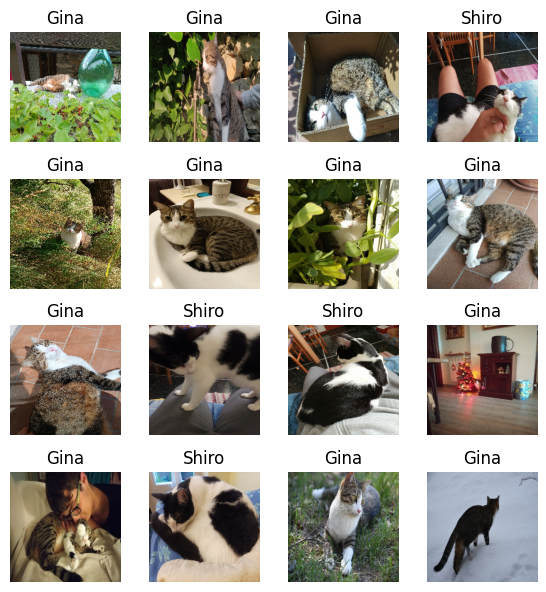

In [6]:
n_rows = 4 # columns of the subplpots
n_cols = 4 # rows of the subplots
plt.figure(figsize=(6,6)) # size of images
for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
    plt.subplot(n_rows,n_cols,i+1)
    plt.imshow(img/255) # normlalize images
    plt.axis('off') # remove axis
    plt.tight_layout(pad=1.0) # add padding between images
    plt.title('Gina' if not(label) else 'Shiro') # set lables
plt.show()

## Process the dataset

### Resize images

In [8]:
learning_dataset    = learning_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))
validation_dataset  = validation_dataset.map(lambda x,y: (tf.image.resize(x,image_sizes[:2]),y))
#tdat = tdat.map(lambda x,y: (tf.image.resize(x,image_sizes),y))

### Visualize cropped images

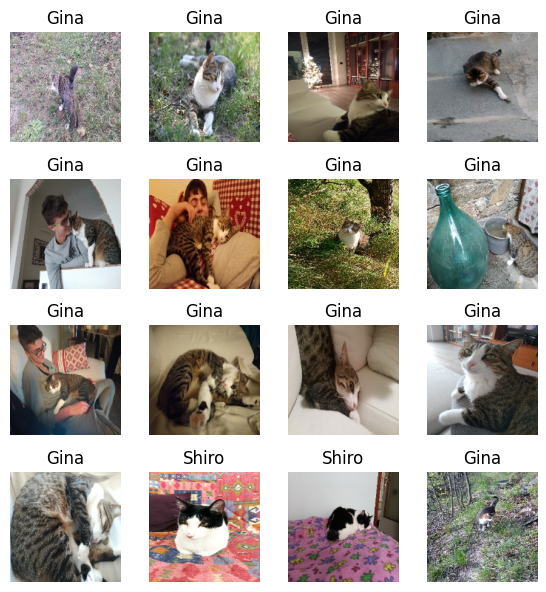

In [ ]:
n_rows = 4 # columns of the subplpots
n_cols = 4 # rows of the subplots
plt.figure(figsize=(6,6)) # size of images
for i, (img,label) in enumerate(learning_dataset.take(n_rows*n_cols)):
    plt.subplot(n_rows,n_cols,i+1)
    plt.imshow(img/255) # normlalize images
    plt.axis('off') # remove axis
    plt.tight_layout(pad=1.0) # add padding between images
    plt.title('Gina' if not(label) else 'Shiro') # set lables
plt.show()

### Apply batching

In [ ]:
learning_dataset = learning_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#tdat = tdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

### Apply data agumentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1)
])

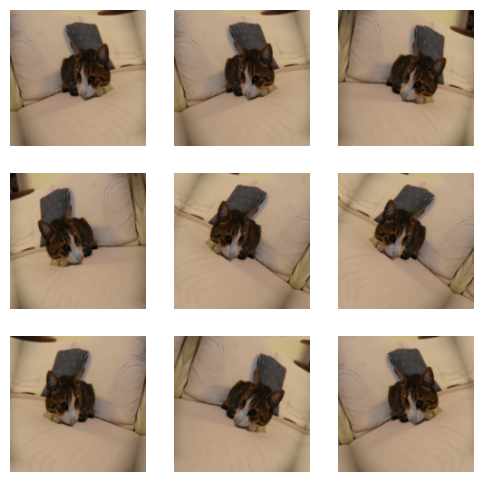

In [ ]:
n_rows = 3  # columns of the subplpots
n_cols = 3 # rows of the subplots
plt.figure(figsize=(6,6)) # size of images
for i, (img,label) in enumerate(learning_dataset.take(1)):
    img = img[0]
    for i in range(n_rows*n_cols):
      plt.subplot(n_rows,n_cols,i+1)
      aug_img = data_augmentation(tf.expand_dims(img,0),training=True)
      plt.imshow(aug_img[0]/255) # normlalize images
      plt.axis('off') # remove axis
plt.show()

## Train the model

In [ ]:
pretrained_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

In [ ]:
pretrained_model.trainable = False

In [ ]:
input = keras.Input(shape=(150,150,3))
x = data_augmentation(input)
x = keras.layers.Rescaling(scale=1./(255/2),offset=-1)(x)
x = pretrained_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(inputs = input,outputs = output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss      = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics   = [keras.metrics.BinaryAccuracy()]
)

In [ ]:
model.fit(
    learning_dataset,
    epochs=4,
    validation_data=validation_dataset
)

Epoch 1/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - binary_accuracy: 0.7863 - loss: 0.4303 - val_binary_accuracy: 0.9608 - val_loss: 0.1357
Epoch 2/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - binary_accuracy: 0.9591 - loss: 0.1518 - val_binary_accuracy: 0.9804 - val_loss: 0.0940
Epoch 3/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.9614 - loss: 0.1163 - val_binary_accuracy: 0.9804 - val_loss: 0.0817
Epoch 4/4
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.9766 - loss: 0.0723 - val_binary_accuracy: 0.9804 - val_loss: 0.0869


In [ ]:
#ldat, vdat, tdat = tfds.load('cats_vs_dogs',
#                             split=['train[:40%]', 'train[40%:50%]', 'train[50%:60%]'],
#                             as_supervised=True)

In [ ]:
#type(ldat)

In [ ]:
#print('train: %d' %tf.data.experimental.cardinality(learning_dataset))
#print('valid: %d' %tf.data.experimental.cardinality(validation_dataset))
#print('test:  %d' %tf.data.experimental.cardinality(tdat))

In [ ]:
#ldat.take(9)

In [ ]:
#imm_size = (150,150)
#ldat = ldat.map(lambda x,y: (tf.image.resize(x,imm_size),y))
#vdat = vdat.map(lambda x,y: (tf.image.resize(x,imm_size),y))
#tdat = tdat.map(lambda x,y: (tf.image.resize(x,imm_size),y))

In [ ]:
#batch_size = 32
#ldat = ldat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#vdat = vdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
#tdat = tdat.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#pretrained_model = keras.applications.Xception(
#    weights='imagenet',
#    input_shape=(150,150,3),
#    include_top=False
#)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
#pretrained_model.trainable = False

In [ ]:
#input = keras.Input(shape=(150,150,3))
#x = data_augmentation(input)
#x = keras.layers.Rescaling(scale=1./(255/2),offset=-1)(x)
#x = pretrained_model(x)
#x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)
#output = keras.layers.Dense(1)(x)
#model = keras.Model(inputs = input,outputs = output)
#model.summary()

In [ ]:
#model.compile(
#    optimizer = 'adam',
#    loss      = keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics   = [keras.metrics.BinaryAccuracy()]
#)

In [ ]:
#model.fit(
#    ldat,
#    epochs=4,
#    validation_data=vdat
#)

In [ ]:
pretrained_model.trainable = True
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(0.00001),
    loss      = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics   = [keras.metrics.BinaryAccuracy()]
)

In [ ]:
model.fit(
    ldat,
    epochs=4,
    validation_data=vdat
)

Epoch 1/4
291/291 ━━━━━━━━━━━━━━━━━━━━ 130s 349ms/step - binary_accuracy: 0.8748 - loss: 0.3271 - val_binary_accuracy: 0.9596 - val_loss: 0.1098
Epoch 2/4
291/291 ━━━━━━━━━━━━━━━━━━━━ 99s 340ms/step - binary_accuracy: 0.9195 - loss: 0.1831 - val_binary_accuracy: 0.9703 - val_loss: 0.0926
Epoch 3/4
291/291 ━━━━━━━━━━━━━━━━━━━━ 99s 341ms/step - binary_accuracy: 0.9432 - loss: 0.1394 - val_binary_accuracy: 0.9695 - val_loss: 0.0825
Epoch 4/4
291/291 ━━━━━━━━━━━━━━━━━━━━ 104s 358ms/step - binary_accuracy: 0.9565 - loss: 0.1033 - val_binary_accuracy: 0.9716 - val_loss: 0.0751
